We have to add the `git` repositories of `scanpy`, `anndata` and `anndata2ri` to the search path for Python packages, otherwise the notebook won't load the most recent packages.

In [2]:
import sys
import os, fnmatch 

In [3]:
sys.path.append('/home/icb/maren.buettner/Python/scanpy/')
sys.path.append('/home/icb/maren.buettner/Python/anndata/')
sys.path.append('/home/icb/maren.buettner/Python/anndata2ri/')

In [4]:
import anndata
import scanpy as sc
import scipy as sci
sc.logging.print_versions()

scanpy==1.4.5.dev65+g67d51e4 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.0 scipy==1.3.1 pandas==0.25.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [5]:
sc.settings.verbosity = 3

In [6]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import datetime
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

In [7]:
import rpy2.rinterface_lib.callbacks
import logging
import anndata2ri

from rpy2.robjects import pandas2ri

In [11]:
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# Introduction

We integrate several datasets, which studied the mouse brain or which contain mouse brain cell data. These datasets are partly annotated. We summarize the dataset in the following table.

|study | sample size | annotated| brain regions annotated| 
|------|-------------|----------|------------------------|
|Tabula Muris| ca. 100k (10k brain)| yes | yes |
|10X Genomics | 1.3 mio | no | no |
|10X Genomics (v3 chemistry) | 11k | no | no|
|Saunders (2018, Cell) | 690k | yes | yes |
|Zeisel (2018, Cell) | 160k | yes | yes |
|Hammond (2018, Immunity) | 76k (microglia) | no | no |
|Rosenberg (2018, Science) | 133k (brain and spinal cord) | yes | partially |

We include the following data sets in our analysis from Tabula Muris, Saunders et al, Zeisel et al, and Rosenberg et al. This yields 978k cells in total. 

# Read data

## Saunders et al (2018)
This study sequenced 690k cells from several regions of the mouse brain to create an atlas of the cell type specialisation. The authors provide data sets sorted by brain region, which contains much more cells than the 'by class' files. The problem here is that the 'by region' files contain also low-quality cells. 

The authors provided additional 'outcome' files containing the cell annotation and if it was filtered out or not. We will use the cluster information from these files to annotate the cells.

We downloaded the data files and the 'outcome' files separated by region from http://dropviz.org/.

In [12]:
path_dir = './../../DL_annotation/mouse_brain_data/Saunders_2018/'
listOfFiles = os.listdir(path= path_dir)

Convert the cell annotations from the R object `RDS` file format to `csv`.

In [15]:
%%R -i path_dir 

filelist <- list.files(path_dir, pattern='.RDS')

for (file_idx in filelist){
  file_out <- gsub('.RDS', '.csv', file_idx)
  data = readRDS(paste0(path_dir, file_idx))
  write.csv(x = data, file = paste0(path_dir, file_out), quote = FALSE)
}

Read `dge` files and convert them to `anndata` objects. 

Please note that `dge` files states first all gene names, then the barcodes, then the count matrix in sparse format, which can be read by scanpy's `read_mtx` function.

In [ ]:
pattern = "F_GRC*.dge.txt"  
adatas = []
for entry in listOfFiles:  
    if fnmatch.fnmatch(entry, pattern):
        print(entry)
        gene_names = list()
        cell_names = list()
        #read gene names and cell barcodes from file
        s = [line.strip() for line in open(path_dir + entry)]
        for line in s:
            if line.startswith('%%GENES'):
                tmp = line.split('\t')
                gene_names = gene_names + tmp[1:]
            if line.startswith('%%CELL_BARCODES'):
                tmp =line.split('\t')
                cell_names = cell_names + tmp[1:]
        #read values and set gene_names and var_names        
        adata = sc.read_mtx(path_dir + entry).T
        adata.var_names = gene_names
        adata.obs_names = cell_names
        
        adata.obs['region'] = [string.split('Rep')[0][3:] for string in adata.obs_names]
        #reduce data by low-quality cells
        entry_prefix = entry.split('.raw')[0] 
        outcome = pd.read_csv(path_dir + entry_prefix + '.cell_cluster_outcomes.csv', index_col=0)
        #outcome = 
        
        adata.obs['cluster'] = outcome['cluster']
        adata.obs['subcluster'] = outcome['subcluster']
        adata.obs['reason'] = outcome['reason']
        adata = adata[np.invert(np.isnan(adata.obs['cluster']))].copy()
        adatas.append(adata)

adata_saunders = adatas[0].concatenate(adatas[1:]).copy()    

F_GRCm38.81.P60Cortex_noRep5_FRONTALonly.raw.dge.txt


**Comment:** The dataset with 'Microglia' also contains macrophages. In total, the published dataset contains approx. 690k cells (approx. the same as reported). 

In [25]:
adata_saunders

AnnData object with n_obs × n_vars = 691962 × 20659 
    obs: 'batch', 'cluster', 'reason', 'region', 'subcluster'

As a precaution, write data to file.

In [26]:
sc.write(adata=adata_saunders, filename='saunders_regions.h5ad')

... storing 'reason' as categorical
... storing 'region' as categorical
... storing 'subcluster' as categorical


In [135]:
adata_saunders = sc.read('saunders_regions.h5ad')

In [136]:
adata_saunders.obs['region'].value_counts()

Hippo        113507
FC           101257
PC            99186
TH            89561
STR           77454
GPNB          66318
SN            44416
FCAldh1l1     30709
CB            26139
FCCx3cr1      24201
ENTSTN        19214
Name: region, dtype: int64

I'd have to assign the following regions: 

|acronym|full name|
|-|-|
|TH|Thalamus|
|Hippo|Hippocampus|
|FC| Frontal Cortex|
|PC|Posterior Cortex|
|GPNB| Globus pallidus and nucleus basalis|
|STR| Striatum|
|SN| Substantia Nigra|
|CB| Cerebellum|
|FCAldh1l1| |
|ENTSTN| Entopeduncular nucleus and subthalamic nucleus|
|FCCx3cr1| |

In order to unify the annotation, we have to see how to deal with GPNB and ENTSTN. In the other data sets, they are assigned at most as 'basal ganglion' (BG), which we should consider as well. Furthermore, the FC and PC section should be summarized to Cortex (CTX).

As a first step, I merge the groups of the frontal cortex (FC): FC + FCAldh1l1 + FCCx3cr1. The latter groups belong to specific mouse lines, but are sampled from the frontal cortex.

In [137]:
adata_saunders.obs['region'].loc[adata_saunders.obs['region']=='FCAldh1l1'] = 'FC'
adata_saunders.obs['region'].loc[adata_saunders.obs['region']=='FCCx3cr1'] = 'FC'
adata_saunders.obs['region'] = adata_saunders.obs['region'].cat.remove_unused_categories()

In [138]:
adata_saunders.obs['region'].value_counts()

FC        156167
Hippo     113507
PC         99186
TH         89561
STR        77454
GPNB       66318
SN         44416
CB         26139
ENTSTN     19214
Name: region, dtype: int64

Make all region names upper case.

In [139]:
adata_saunders.obs['region'] = adata_saunders.obs['region'].cat.rename_categories(lambda x: x.upper())

In [229]:
tissue_dict = dict({'HIPPO' : 'HC' , 'GPNB' : 'GP', 'ENTSTN' : 'ENT' })

Rename regions such that they correspond to the labels in the annotation file.

In [230]:
adata_saunders.obs['region'] = adata_saunders.obs['region'].cat.rename_categories(tissue_dict)

In [231]:
adata_saunders.obs['region'].value_counts()

FC     156167
HC     113507
PC      99186
TH      89561
STR     77454
GP      66318
SN      44416
CB      26139
ENT     19214
Name: region, dtype: int64

In [232]:
pd.crosstab(adata_saunders.obs['cluster'],adata_saunders.obs['region'])

region      CB    ENT     FC     GP     HC     PC     SN    STR     TH
cluster                                                               
1.0      21331  11672   6280    437   6424   8164     73    514   1114
2.0        178   2437   5386  11103   6337  51800    297   1527  33094
3.0       1547    604  14250   9847   4565   4764  10049   3824   6361
4.0        229   2608   3294   2354  27882   3161   1841   5082   9198
5.0         64    454   1149   9874  19183   2779    593   1186   2226
6.0        347    272  83536     53  15141   7869    300   1094    450
7.0       1404    748   5367   6089  16380   1224   3042   1819    443
8.0        326    337  10394   2103   5050   7430     48    891  32452
9.0         50      4   8718    457   2282   3814    237    220    319
10.0       422     10   2865  23184   1307   1353  20804  30835    753
11.0       241      1   2193    770    715   1017    354  25305   2139
12.0         0     13   9227      1     44   3797   4654    320    975
13.0         0      6   2529     16    988   1079   1717   2744     17
14.0         0     11    944      6    672    904    357   1517     19
15.0         0     18      9      1   4233      2      2    555      1
16.0         0     18      4      3   1569     14     17      2      0
17.0         0      1     15      5    676     10      6      2      0
18.0         0      0      7     15     10      5     10      2      0
19.0         0      0      0      0     18      0     11     15      0
20.0         0      0      0      0      5      0      4      0      0
21.0         0      0      0      0     14      0      0      0      0
22.0         0      0      0      0     12      0      0      0      0

In [303]:
annotation = pd.read_csv('./../../DL_annotation/mouse_brain_data/Saunders_2018/annotation.BrainCellAtlas_Saunders_version_2018.04.01.txt', 
                         sep='\t', encoding='latin1')

In [43]:
annotation

tissue              class      class_marker        type_marker  \
0       CB             NEURON           Slc17a7             Gabra6   
1       CB  ENDOTHELIAL_STALK              Flt1                Mgp   
2       CB  ENDOTHELIAL_STALK              Flt1               Car4   
3       CB  ENDOTHELIAL_STALK              Flt1               Lrg1   
4       CB    ENDOTHELIAL_TIP               Dcn               Nnat   
5       CB    ENDOTHELIAL_TIP               Dcn               Apod   
6       CB              MURAL         Acta2Rgs5              Acta2   
7       CB              MURAL         Acta2Rgs5              Kcnj8   
8       CB              MURAL         Acta2Rgs5               Rgs5   
9       CB             NEURON          Gad1Gad2               Pcp2   
10      CB             NEURON          Gad1Gad2         Pvalb-Nefh   
11      CB             NEURON          Gad1Gad2        Pvalb-Rab3b   
12      CB             NEURON          Gad1Gad2        Pvalb-Cadm1   
13      CB             NEURON          Gad1Gad2      Pvalb - Chrm2   
14      CB             NEURON           Slc17a6                Sln   
15      CB             NEURON          Gad1Gad2               Lgi2   
16      CB             NEURON           Slc17a6               Nrgn   
17      CB          MICROGLIA              C1qb       Mrc1-Tmem119   
18      CB    OLIGODENDROCYTE               Trf               Il33   
19      CB    OLIGODENDROCYTE               Trf               Klk6   
20      CB     POLYDENDROCYTE               Tnr                Tnr   
21      CB          ASTROCYTE               Gja             Slc1a3   
22      CB          ASTROCYTE              Gja1               Gfap   
23      CB          ASTROCYTE              Gja1              Htra1   
24      CB     CHOROID_PLEXUS               Ttr                Ttr   
25      FC             NEURON          Gad1Gad2          Cplx3-Npy   
26      FC             NEURON  Gad1Gad2-Slc17a8  Synpr-Sncg-Yjefn3   
27      FC             NEURON          Gad1Gad2         Synpr-Sncg   
28      FC             NEURON          Gad1Gad2         Cplx3-Reln   
29      FC             NEURON          Gad1Gad2         Synpr-Nnat   
..     ...                ...               ...                ...   
535     TH             NEURON           Slc17a6         Rora.Fgf10   
536     TH             NEURON           Slc17a6         Rora.Lypd6   
537     TH             NEURON           Slc17a6         Rora.Cbln2   
538     TH             NEURON           Slc17a6        Rora.Lrrtm2   
539     TH             NEURON          Gad1Gad2         Six3-Adcy1   
540     TH             NEURON           Slc17a6               Ebf1   
541     TH             NEURON          Gad1Gad2                Ttn   
542     TH             NEURON          Gad1Gad2           Six3-Sst   
543     TH             NEURON          Gad1Gad2        Pou6f2-Pax6   
544     TH             NEURON           Slc17a6              Pitx2   
545     TH             NEURON          Gad1Gad2             Chrnb3   
546     TH             NEURON          Gad1Gad2              Gata3   
547     TH             NEURON  Slc17a6-Gad1Gad2               Asb4   
548     TH             NEURON          Gad1Gad2            Col25a1   
549     TH             NEURON           Slc17a6               Nrgn   
550     TH  ENDOTHELIAL_STALK              Flt1               Gkn3   
551     TH  ENDOTHELIAL_STALK              Flt1               Pi16   
552     TH  ENDOTHELIAL_STALK              Flt1               Car4   
553     TH  ENDOTHELIAL_STALK              Flt1                Vwf   
554     TH              MURAL         Rgs5Acta2               Cnn1   
555     TH              MURAL         Rgs5Acta2               Car4   
556     TH    ENDOTHELIAL_TIP               Dcn                Dcn   
557     TH    ENDOTHELIAL_TIP               Dcn           Dcn.Nenf   
558     TH         MACROPHAGE              C1qb               Mrc1   
559     TH          MICROGLIA              C1qb            Tmem119   
560     TH    

The annotation file uses a tissue subcluster code for the annotation of the respective subclusters. If the cluster and subcluster assignment is the same, add '-1' to the subcluster label, because we have the the main cluster label often used in the subcluster assignment as well, which interferes with the subsequent annotation using the annotation file.
Further, I will add the region to the subcluster assignment in the data set in order to obtain a human readable legend of the data.

In [304]:
annotation.loc[annotation['tissue']=='FC']

tissue              class             class_marker          type_marker  \
25      FC             NEURON                 Gad1Gad2            Cplx3-Npy   
26      FC             NEURON         Gad1Gad2-Slc17a8    Synpr-Sncg-Yjefn3   
27      FC             NEURON                 Gad1Gad2           Synpr-Sncg   
28      FC             NEURON                 Gad1Gad2           Cplx3-Reln   
29      FC             NEURON                 Gad1Gad2           Synpr-Nnat   
30      FC             NEURON                 Gad1Gad2       Synpr-Crispld2   
31      FC             NEURON            Gad1Gad2-Chat         Synpr-Slc5a7   
32      FC             NEURON                 Gad1Gad2        Synpr-Pcdh11x   
33      FC             NEURON                 Gad1Gad2        Synpr-Dpy19l1   
34      FC             NEURON                 Gad1Gad2        Cplx3-Dpy19l1   
35      FC             NEURON                 Gad1Gad2          Cplx3-Crim1   
36      FC     POLYDENDROCYTE                      Tnr                Cspg5   
37      FC     POLYDENDROCYTE                      Tnr                 Dlx1   
38      FC     POLYDENDROCYTE                      Tnr                Pdgfa   
39      FC     POLYDENDROCYTE                      Tnr               Opalin   
40      FC     POLYDENDROCYTE                      Tnr          Bmp4- Ptgds   
41      FC     POLYDENDROCYTE                      Tnr           Bmp4-Gpr17   
42      FC          MICROGLIA                     C1qb              Tmem119   
43      FC             NEURON                  Slc17a6                 Reln   
44      FC         MACROPHAGE                     C1qb                 Mrc1   
45      FC          MICROGLIA                     C1qb          Tmem119-Fos   
46      FC  ENDOTHELIAL_STALK                     Flt1                 Gkn3   
47      FC  ENDOTHELIAL_STALK                     Flt1                  Mgp   
48      FC  ENDOTHELIAL_STALK                     Flt1                 Car4   
49      FC  ENDOTHELIAL_STALK                     Flt1                  Cfh   
50      FC  ENDOTHELIAL_STALK                     Flt1                 Lrg1   
51      FC              MURAL                Rgs5Acta2                 Cnn1   
52      FC              MURAL                Rgs5Acta2                Ccnd1   
53      FC              MURAL                Rgs5Acta2                Abcc9   
54      FC              MURAL                Rgs5Acta2               Col3a1   
..     ...                ...                      ...                  ...   
76      FC             NEURON                  Slc17a7           Syt6-Efna5   
77      FC             NEURON                  Slc17a7         Syt6-Cyp26b1   
78      FC             NEURON                  Slc17a7         Syt6-Slc30a3   
79      FC             NEURON                  Slc17a7         Syt6-Slc24a2   
80      FC             NEURON                  Slc17a7           Syt6-Lypd1   
81      FC             NEURON          Slc17a7-Slc17a6            Syt6-Nnat   
82      FC             NEURON                  Slc17a7          Syt6-Sema3c   
83      FC             NEURON  Slc17a6-Slc17a7-Slc17a8        Fezf2.Slc17a8   
84      FC             NEURON          Slc17a6-Slc17a7  Fezf2.3110035E14Rik   
85      FC             NEURON          Slc17a6-Slc17a7                Nr4a2   
86      FC             NEURON                  Slc17a7          Nptxr-Calb1   
87      FC             NEURON                  Slc17a7          Nptxr-Ndst4   
88      FC             NEURON          Slc17a7-Slc17a6           Nptxr-Rorb   
89      FC             NEURON                  Slc17a7         Nptxr-Deptor   
90      FC             NEURON                  Slc17a7            Nptxr-Fos   
91      FC             NEURON                  Slc17a7           Nptxr-Drd1   
92      FC             NEURON                  Slc17a7           Parm1.Ndnf   
93      FC             NEURON                  Slc17a7           Parm1.Nnat   
94      FC             NEURON                  Slc17a7

In [141]:
cluster_subcluster_idx = adata_saunders.obs['cluster'].astype('int').astype('str') == adata_saunders.obs['subcluster']

In [142]:
cluster_subcluster_idx.sum()

375416

In [194]:
subclusters_to_add = [name + '-1' for name in list(set(adata_saunders.obs['subcluster'].cat.categories)- set(annotation['subcluster']))]

subclust_dict = dict(zip(list(set(adata_saunders.obs['subcluster'].cat.categories)- set(annotation['subcluster'])), subclusters_to_add))

In [214]:
for idx in enumerate(subclust_dict):
    if np.invert(np.in1d(subclust_dict[idx[1]],adata_saunders.obs['subcluster'].cat.categories)):
        adata_saunders.obs['subcluster'] = adata_saunders.obs['subcluster'].cat.add_categories(subclust_dict[idx[1]]) 
    adata_saunders.obs['subcluster'].loc[adata_saunders.obs['subcluster']==idx[1]] = subclust_dict[idx[1]]   

Merge labels of region and subcluster assignment.

In [234]:
adata_saunders.obs['region_subcluster'] = np.array([str(adata_saunders.obs['region'][name[0]]) + '_' + str(adata_saunders.obs['subcluster'][name[0]]) for name in enumerate(adata_saunders.obs_names)])

In [235]:
adata_saunders.obs['region_subcluster'] = adata_saunders.obs['region_subcluster'].astype('category')

Add cell type label using the annotation file.

In [236]:
df = annotation[['tissue_subcluster','class']].set_index('tissue_subcluster').to_dict()

In [237]:
np.unique(annotation['class'])

array(['ASTROCYTE', 'CHOROID_PLEXUS', 'ENDOTHELIAL_STALK',
       'ENDOTHELIAL_TIP', 'EPENDYMAL', 'MACROPHAGE', 'MICROGLIA',
       'MITOTIC', 'MURAL', 'NEUROGENESIS', 'NEURON', 'OLIGODENDROCYTE',
       'POLYDENDROCYTE'], dtype=object)

In [238]:
adata_saunders.obs['class'] = adata_saunders.obs['region_subcluster'].cat.add_categories(np.unique(annotation['class']))

for idx in enumerate(df['class']):
    adata_saunders.obs['class'].loc[adata_saunders.obs['class']==idx[1]] = df['class'][idx[1]]
    
adata_saunders.obs['class'] = adata_saunders.obs['class'].cat.remove_unused_categories()

Add refined cell types using the annotation file.

In [245]:
df2 = annotation[['tissue_subcluster','full_name']].set_index('tissue_subcluster').to_dict()

In [248]:
adata_saunders.obs['refined_class'] = adata_saunders.obs['region_subcluster'].cat.add_categories(np.unique(annotation['full_name']))

for idx in enumerate(df2['full_name']):
    adata_saunders.obs['refined_class'].loc[adata_saunders.obs['refined_class']==idx[1]] = df2['full_name'][idx[1]]
    
adata_saunders.obs['refined_class'] = adata_saunders.obs['refined_class'].cat.remove_unused_categories()

Check for outliers.

In [240]:
adata_saunders.obs['class'].cat.categories

Index(['ENT_10-1', 'ENT_11-1', 'ENT_12-1', 'ENT_13-1', 'ENT_14-1', 'ENT_15-1',
       'ENT_16-1', 'ENT_17-1', 'ENT_9-1', 'FC_15-1', 'FC_16-1', 'FC_17-1',
       'FC_18-1', 'GP_12-1', 'GP_13-1', 'GP_14-1', 'GP_15-1', 'GP_16-1',
       'GP_17-1', 'GP_18-1', 'HC_18-1', 'HC_19-1', 'HC_20-1', 'HC_21-1',
       'HC_22-1', 'PC_15-1', 'PC_16-1', 'PC_17-1', 'PC_18-1', 'SN_15-1',
       'SN_16-1', 'SN_17-1', 'SN_18-1', 'SN_19-1', 'SN_20-1', 'STR_16-1',
       'STR_17-1', 'STR_18-1', 'STR_19-1', 'TH_13-1', 'TH_14-1', 'TH_15-1',
       'ASTROCYTE', 'CHOROID_PLEXUS', 'ENDOTHELIAL_STALK', 'ENDOTHELIAL_TIP',
       'EPENDYMAL', 'MACROPHAGE', 'MICROGLIA', 'MITOTIC', 'MURAL',
       'NEUROGENESIS', 'NEURON', 'OLIGODENDROCYTE', 'POLYDENDROCYTE'],
      dtype='object')

In [241]:
pd.crosstab(adata_saunders.obs['class'],adata_saunders.obs['region'])

region                CB    ENT      FC     GP     HC     PC     SN    STR  \
class                                                                        
ENT_10-1               0     10       0      0      0      0      0      0   
ENT_11-1               0      1       0      0      0      0      0      0   
ENT_12-1               0     13       0      0      0      0      0      0   
ENT_13-1               0      6       0      0      0      0      0      0   
ENT_14-1               0     11       0      0      0      0      0      0   
ENT_15-1               0     18       0      0      0      0      0      0   
ENT_16-1               0     18       0      0      0      0      0      0   
ENT_17-1               0      1       0      0      0      0      0      0   
ENT_9-1                0      4       0      0      0      0      0      0   
FC_15-1                0      0       9      0      0      0      0      0   
FC_16-1                0      0       4      0      0      0      0      0   
FC_17-1                0      0      15      0      0      0      0      0   
FC_18-1                0      0       7      0      0      0      0      0   
GP_12-1                0      0       0      1      0      0      0      0   
GP_13-1                0      0       0     16      0      0      0      0   
GP_14-1                0      0       0      6      0      0      0      0   
GP_15-1                0      0       0      1      0      0      0      0   
GP_16-1                0      0       0      3      0      0      0      0   
GP_17-1                0      0       0      5      0      0      0      0   
GP_18-1                0      0       0     15      0      0      0      0   
HC_18-1                0      0       0      0     10      0      0      0   
HC_19-1                0      0       0      0     18      0      0      0   
HC_20-1                0      0       0      0      5      0      0      0   
HC_21-1                0      0       0      0     14      0      0      0   
HC_22-1                0      0       0      0     12      0      0      0   
PC_15-1                0      0       0      0      0      2      0      0   
PC_16-1                0      0       0      0      0     14      0      0   
PC_17-1                0      0       0      0      0     10      0      0   
PC_18-1                0      0       0      0      0      5      0      0   
SN_15-1                0      0       0      0      0      0      2      0   
SN_16-1                0      0       0      0      0      0     17      0   
SN_17-1                0      0       0      0      0      0      6      0   
SN_18-1                0      0       0      0      0      0     10      0   
SN_19-1                0      0       0      0      0      0     11      0   
SN_20-1                0      0       0      0      0      0      4      0   
STR_16-1               0      0       0      0      0      0      0      2   
STR_17-1               0      0       0      0      0      0      0      2   
STR_18-1               0      0       0      0      0      0      0      2   
STR_19-1               0      0       0      0      0      0      0     15   
TH_13-1                0      0       0      0      0      0      0      0   
TH_14-1                0      0       0      0      0      0      0      0   
TH_15-1                0      0       0      0      0      0      0      0   
ASTROCYTE           1730    748   10394   9874  16380   7430   3042   5082   
CHOROID_PLEXUS        50      0       0      0     44      0      0      0   
ENDOTHELIAL_STALK    422   2437    9227   6089   4233   3797   4654   1819   
ENDOTHELIAL_TIP      174     37     944    457    676    904    357    220   
EPENDYMAL              0      0       0     53    715      0     48    514   
MACROPHAGE             0      0     149    122     78    102    217    706   
MICROGLIA             64      0    2014    648   1229    915     20    388   
MITOTIC               

After human readable assignment, we are going to remove all clusters, which have not received a 'human readable' assignment. Further, we remove mitotic cells.

In [253]:
remove_idx = np.in1d(adata_saunders.obs['class'],['ENT_10-1', 'ENT_11-1', 'ENT_12-1', 'ENT_13-1', 'ENT_14-1', 'ENT_15-1',
       'ENT_16-1', 'ENT_17-1', 'ENT_9-1', 'FC_15-1', 'FC_16-1', 'FC_17-1',
       'FC_18-1', 'GP_12-1', 'GP_13-1', 'GP_14-1', 'GP_15-1', 'GP_16-1',
       'GP_17-1', 'GP_18-1', 'HC_18-1', 'HC_19-1', 'HC_20-1', 'HC_21-1',
       'HC_22-1', 'PC_15-1', 'PC_16-1', 'PC_17-1', 'PC_18-1', 'SN_15-1',
       'SN_16-1', 'SN_17-1', 'SN_18-1', 'SN_19-1', 'SN_20-1', 'STR_16-1',
       'STR_17-1', 'STR_18-1', 'STR_19-1', 'TH_13-1', 'TH_14-1', 'TH_15-1','MITOTIC', 'CHOROID_PLEXUS'])

In [254]:
adata_saunders = adata_saunders[np.invert(remove_idx)].copy()

In [255]:
adata_saunders.n_obs

691489

In [256]:
pd.crosstab(adata_saunders.obs['class'],adata_saunders.obs['region'])

region                CB    ENT      FC     GP     HC     PC     SN    STR  \
class                                                                        
ASTROCYTE           1730    748   10394   9874  16380   7430   3042   5082   
ENDOTHELIAL_STALK    422   2437    9227   6089   4233   3797   4654   1819   
ENDOTHELIAL_TIP      174     37     944    457    676    904    357    220   
EPENDYMAL              0      0       0     53    715      0     48    514   
MACROPHAGE             0      0     149    122     78    102    217    706   
MICROGLIA             64      0    2014    648   1229    915     20    388   
MURAL                 67    567    2529   2103   1569   1079   1717    891   
NEUROGENESIS           0      0       0      0    988      0      0   1527   
NEURON             23285   2608  119292  21387  80204  79761  12260  61276   
OLIGODENDROCYTE      339  12009    8718  23184   5050   3814  21158   3824   
POLYDENDROCYTE         8    726    2865   2337   2282   1353    893   1186   

region                TH  
class                     
ASTROCYTE           2139  
ENDOTHELIAL_STALK   9198  
ENDOTHELIAL_TIP      450  
EPENDYMAL            753  
MACROPHAGE           327  
MICROGLIA            116  
MURAL               2226  
NEUROGENESIS           0  
NEURON             40569  
OLIGODENDROCYTE    32771  
POLYDENDROCYTE       975

In [258]:
sc.write(adata=adata_saunders, filename='saunders_regions.h5ad')

In [300]:
adata_saunders = sc.read('saunders_regions.h5ad')

Let us refine and resolve the endothelial regime of the data set.

In [305]:
adata_endo = adata_saunders[np.in1d(adata_saunders.obs['class'], 
                                    ['MURAL', 'ENDOTHELIAL_STALK', 'ENDOTHELIAL_TIP'])].copy()

In [306]:
sc.pp.log1p(adata_endo)
sc.pp.pca(adata_endo)
sc.pp.neighbors(adata_endo)
sc.tl.louvain(adata_endo)
sc.tl.umap(adata_endo)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:39.29) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:12.67) --> found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
computing UMAP
    finished (0:00:56.79) --> added
    'X_umap', UMAP coordinates (adata.obsm)


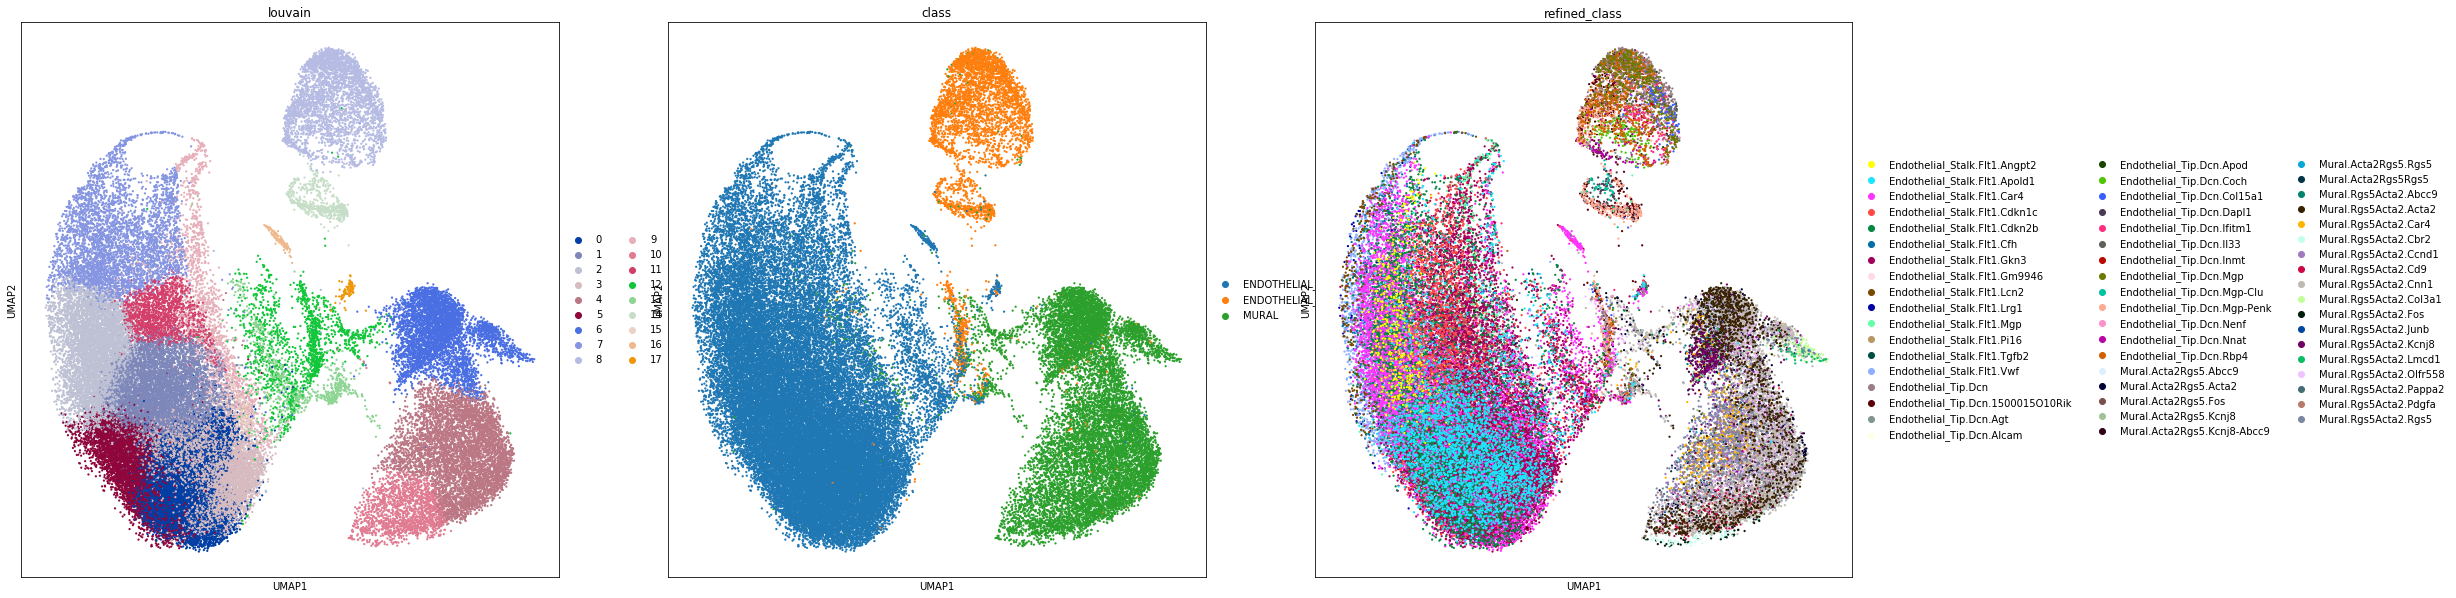

In [309]:
sc.pl.umap(adata_endo, color=['louvain', 'class', 'refined_class'],size=20)

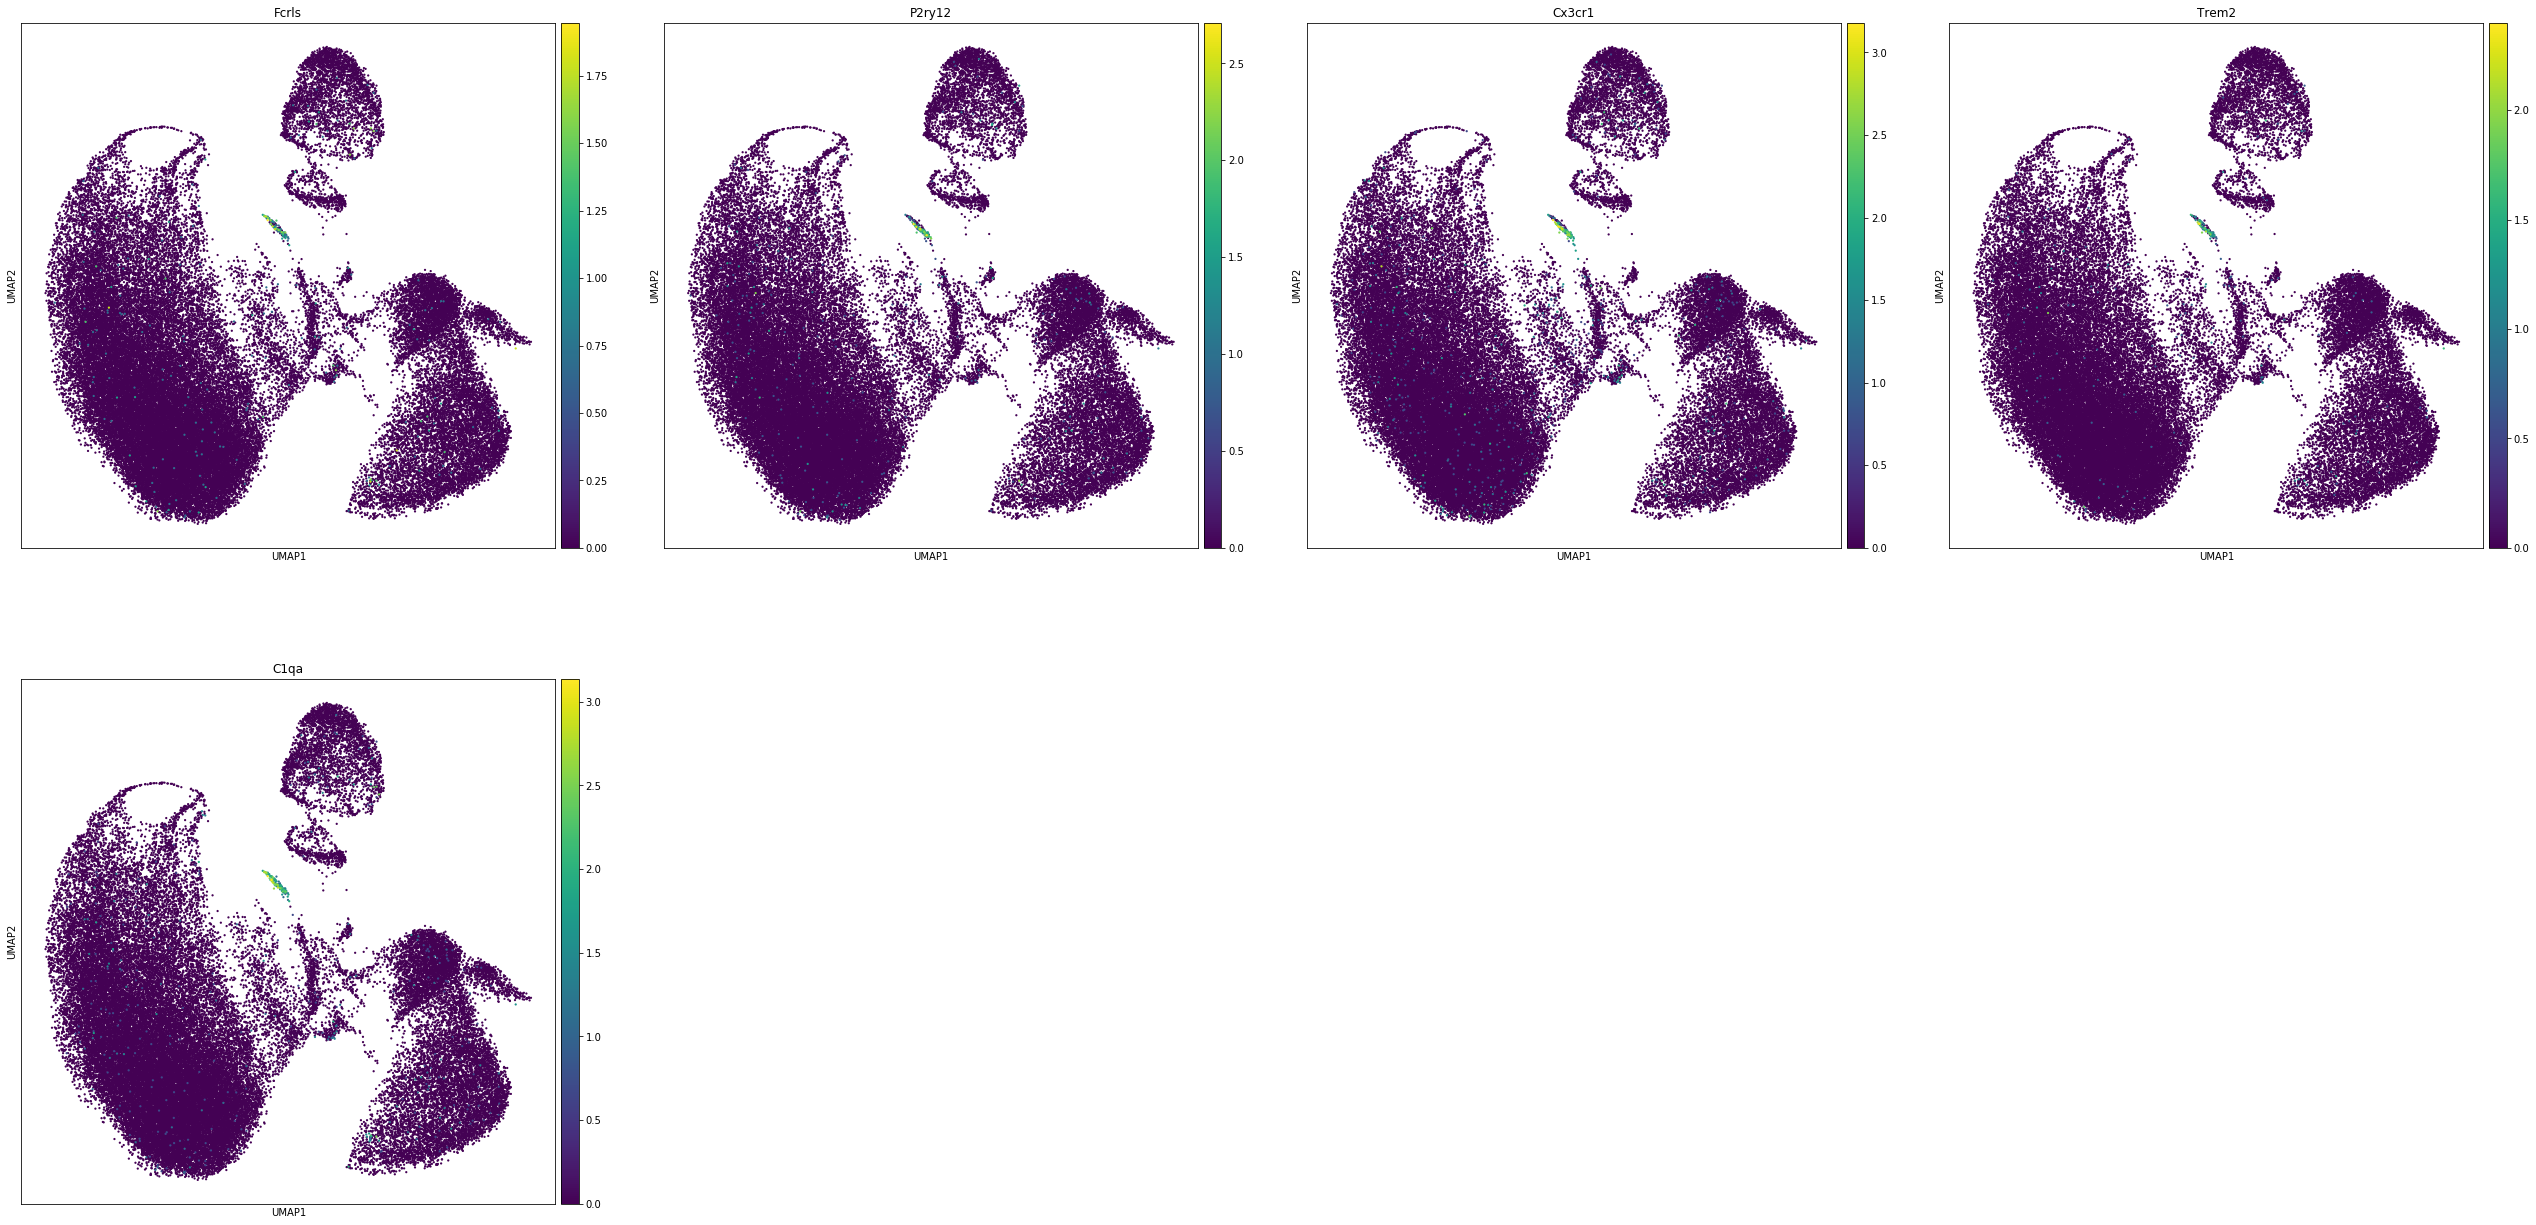

In [315]:
sc.pl.umap(adata_endo, color=['Fcrls', 'P2ry12','Cx3cr1', 'Trem2','C1qa'], size=20)#microglia marker

In [310]:
sc.tl.rank_genes_groups(adata_endo, 'louvain')

ranking genes
    finished (0:00:15.29) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


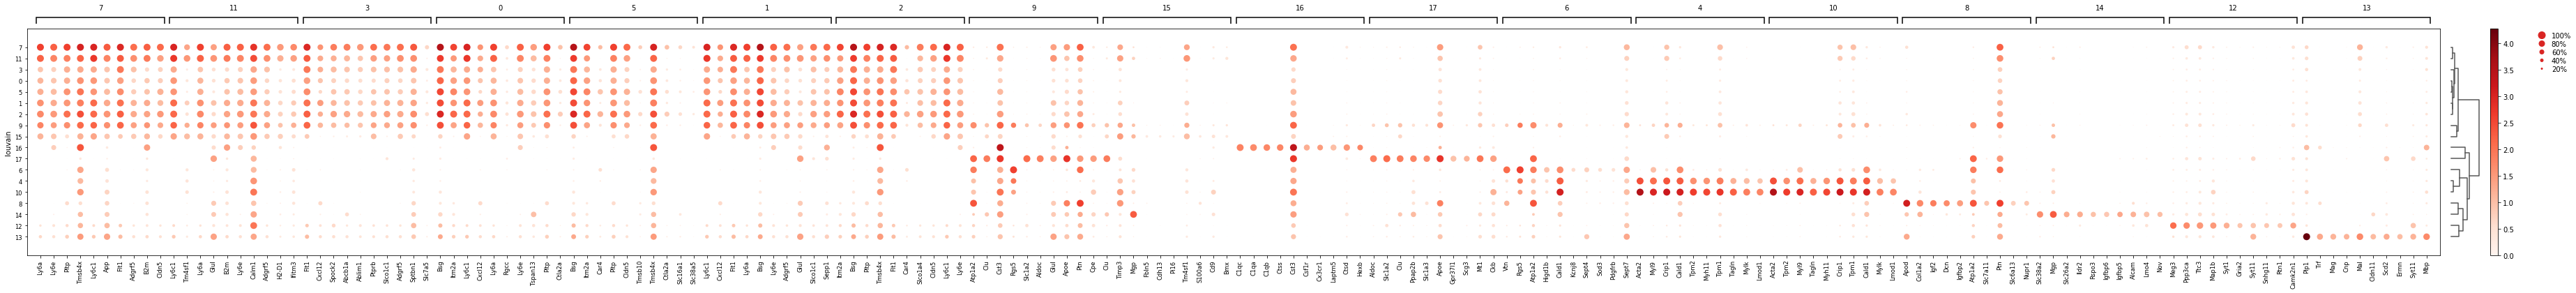

In [312]:
sc.pl.rank_genes_groups_dotplot(adata_endo)

**COMMENTS**: Cluster 16 is a microglia cell cluster. Cluster 13 belongs to oligodendrocytes (Plp1 marker). Cluster 17 is astrocytes (comparison to Tabula Muris). Cluster 4, 6 and 10 are pericytes. 

Let us re-annotate these clusters in the main data set.

In [324]:
tmp = adata_endo.obs['louvain']=='16'

microglia_index = adata_endo.obs['louvain'].loc[tmp].index

tmp = adata_endo.obs['louvain']=='17'

astrocyte_index = adata_endo.obs['louvain'].loc[tmp].index

tmp = np.in1d(adata_endo.obs['louvain'], ['4','6', '10'])

pericyte_index = adata_endo.obs['louvain'].loc[tmp].index

Let us apply the rough annotation into: 
astrocyte, brain pericyte, ependymal cells, macrophage, microglial cell, neuron, (olfactory ensheathing cell), oligodendrocyte, oligodendrocyte precursor cells.

In [301]:
adata_saunders.obs['class'].cat.categories

Index(['ASTROCYTE', 'ENDOTHELIAL_STALK', 'ENDOTHELIAL_TIP', 'EPENDYMAL',
       'MACROPHAGE', 'MICROGLIA', 'MURAL', 'NEUROGENESIS', 'NEURON',
       'OLIGODENDROCYTE', 'POLYDENDROCYTE'],
      dtype='object')

In [343]:
saunders_rough_dict = dict({'ASTROCYTE' : 'astrocyte', 
                            'ENDOTHELIAL_STALK' : 'endothelial cell', 
                            'ENDOTHELIAL_TIP': 'endothelial cell', 
                            'EPENDYMAL': 'ependymal cell' ,
                            'MACROPHAGE': 'macrophage', 
                            'MICROGLIA' : 'microglial cell',
                            'MURAL': 'endothelial cell',
                            'NEUROGENESIS': 'neuron',
                            'NEURON' : 'neuron',
                            'OLIGODENDROCYTE': 'oligodendrocyte', 
                            'POLYDENDROCYTE' : 'oligodendrocyte precursor cell'})
df1 = pd.DataFrame.from_dict(saunders_rough_dict, orient='index')

In [334]:
np.unique(df1[0])

array(['astrocyte', 'endothelial cell', 'ependymal cell', 'macrophage',
       'microglial cell', 'neuron', 'oligodendrocyte',
       'oligodendrocyte precursor cells'], dtype=object)

In [348]:
adata_saunders.obs['cell_type'] = adata_saunders.obs['class'].cat.add_categories(['astrocyte', 
                            'endothelial cell', 'ependymal cell', 'macrophage',
       'microglial cell', 'neuron', 'oligodendrocyte',
       'oligodendrocyte precursor cell', 'brain pericyte'])

In [349]:
for idx in enumerate(df1[0]):
    adata_saunders.obs['cell_type'].loc[adata_saunders.obs['cell_type']==df1[0].index[idx[0]]] = idx[1]
    


In [350]:
adata_saunders.obs['cell_type'][microglia_index] = 'microglial cell'
adata_saunders.obs['cell_type'][astrocyte_index] = 'astrocyte'
adata_saunders.obs['cell_type'][pericyte_index] = 'brain pericyte'

adata_saunders.obs['cell_type'] = adata_saunders.obs['cell_type'].cat.remove_unused_categories()

In [351]:
pd.value_counts(adata_saunders.obs['cell_type'])

neuron                            443157
oligodendrocyte                   110867
astrocyte                          56915
endothelial cell                   46455
oligodendrocyte precursor cell     12625
brain pericyte                     12135
microglial cell                     5551
ependymal cell                      2083
macrophage                          1701
Name: cell_type, dtype: int64

In [352]:
adata_saunders.obs['study'] = 'Saunders'

In [353]:
sc.write(adata=adata_saunders, filename='saunders_regions.h5ad')

... storing 'study' as categorical


Free memory.

In [354]:
del adata_saunders
del adata_endo

## Rosenberg et al (2018)

Rosenberg et al (2018) provided a convenience function written in Python to load their annotated dataset. **Comment:** I love it. The following lines adapt the code of the convenience function.

In [6]:
import scipy.io as sio
import pandas as pd

In [137]:
#Load Data
data = sio.loadmat('./../../DL_annotation/mouse_brain_data/Rosenberg_2018/GSM3017261_nuclei.mat')

#Digital Expression Matrix
DGE = data['DGE']

#Genes
genes = pd.Series(data['genes']).str.strip(' ')

#Sample types
sample_type = pd.Series(data['sample_type']).str.strip(' ')

#Main cluster assignment
cluster_assignment = pd.Series(data['cluster_assignment']).str.strip(' ')

#Spinal cluster assignment
spinal_cluster_assignment = pd.Series(data['spinal_cluster_assignment']).str.strip(' ')

Create an anndata object from the Rosenberg dataset.

Re-annotate the data, but focus on brain tissue.

In [138]:
brain_idx = np.isin(sample_type, ['p2_brain', 'p11_brain'])

In [371]:
adata_rosen = anndata.AnnData(X=DGE[brain_idx,:])
adata_rosen.var_names=genes
adata_rosen.obs['sample_type']=sample_type[brain_idx].values
adata_rosen.obs['cluster'] = cluster_assignment[brain_idx].values

In [372]:
adata_rosen.obs['age'] = np.array([types.split('_')[0] for types in adata_rosen.obs['sample_type']])

In [373]:
adata_rosen

AnnData object with n_obs × n_vars = 133435 × 26894 
    obs: 'sample_type', 'cluster', 'age'

... storing 'sample_type' as categorical
... storing 'cluster' as categorical
... storing 'age' as categorical
/home/icb/maren.buettner/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)


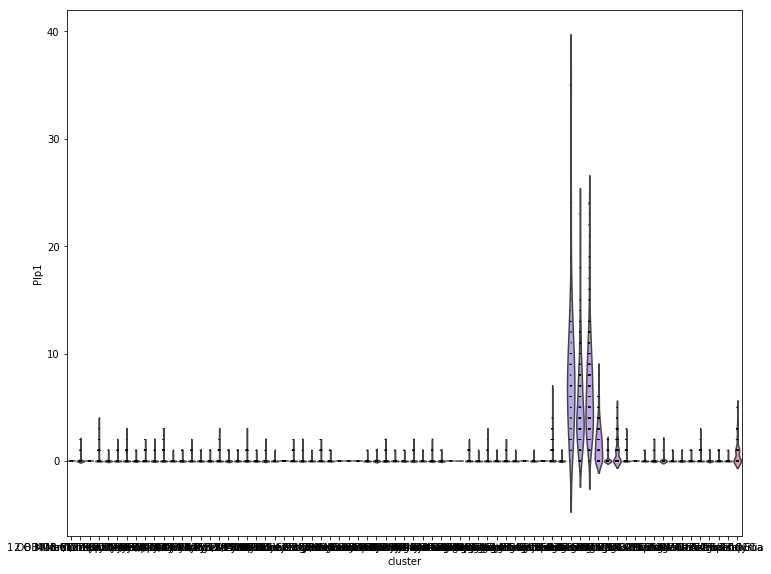

In [374]:
rcParams['figure.figsize']=(10,10)
sc.pl.violin(adata_rosen, 'Plp1', groupby='cluster')

The annotation of the cells is encoded in the `cluster` variable. The neuronal cell types carry a region tag, others don't. In the next step, I split the cell type annotation into the region, if possible, and the respective cell type. 

In [375]:
tmp = np.array([types.split(' ') for types in adata_rosen.obs['cluster']])

In [376]:
adata_rosen.obs['cluster_id'] = np.array([types[0] for types in tmp])
adata_rosen.obs['region'] = np.array([types[1] for types in tmp])

In [377]:
adata_rosen.obs['region'] = adata_rosen.obs['region'].astype('category')

We extract the region information as well as possible. The available regions are:

* HIPP - Hippocampus
* SUB - belongs to Hippocampus
* THAL - Thalamus
* CTX - Cortex
* OB - Olfactory bulb
* Medium - 'Medium spiny neurons' from Striatum (STR)
* CLAU - belongs to Cortex
* CB - cerebellum
* Purkinje - assigned to cerebellum
* MTt - Rostral midbrain (MB)
* MD - medulla
* Nigral - Nigral dopaminergic neurons from Substantia nigra (SN)
* Migrating - interneurons, which we assign to cerebellum (CB)
* SVZ - subventricular zone, close to striatum (STR)
* SC - spinal cord
* OEC - macroglia, which reside in the olfactory bulb

Create a dictionary to assign the regions.

In [378]:
neuro_dict = dict({'HIPP': 'HC', 
                   'SUB' : 'HC', 
                   'THAL' : 'TH', 
                   'Medium' : 'STR',
                   'CLAU' : 'CTX', 
                   'Purkinje' : 'CB', 
                   'MTt' : 'MB',
                   'Nigral' : 'SN',
                   'Migrating': 'CB',
                   'SVZ' : 'STR',
                   'OEC' : 'OB'
                  })

df = pd.DataFrame.from_dict(neuro_dict, orient='index')


In [379]:
adata_rosen.obs['region'] = adata_rosen.obs['region'].cat.add_categories([ 'HC', 'MB', 'STR', 'TH', 'SN'])

for idx in enumerate(df[0]):
    adata_rosen.obs['region'].loc[adata_rosen.obs['region']==df[0].index[idx[0]]] = idx[1]
    
adata_rosen.obs['region'] = adata_rosen.obs['region'].cat.remove_unused_categories()

Next, we remove all categories, where we do not have a region information. 

In [380]:
unknown_region = list(set(adata_rosen.obs['region'].cat.categories) - set(np.unique(df[0])) - set(['OB', 'MD', 'SC']))

In [381]:
adata_rosen.obs['region'] = adata_rosen.obs['region'].cat.add_categories(['Unknown'])

for idx in enumerate(unknown_region):
    adata_rosen.obs['region'].loc[adata_rosen.obs['region']==idx[1]] = 'Unknown'
    
adata_rosen.obs['region'] = adata_rosen.obs['region'].cat.remove_unused_categories()

In [382]:
adata_rosen.obs['region'].value_counts()

Unknown    66648
CB         27163
CTX        22622
STR         8028
HC          4559
TH          2822
MB           730
OB           730
MD            77
SN            43
SC            13
Name: region, dtype: int64

In [383]:
adata_rosen

AnnData object with n_obs × n_vars = 133435 × 26894 
    obs: 'sample_type', 'cluster', 'age', 'cluster_id', 'region'

In [245]:
sc.write(adata=adata_rosen, filename='rosenberg_regions.h5ad')

... storing 'cluster_id' as categorical


Rename and merge clusters.

In [384]:
adata_rosen.obs['cell_type'] = adata_rosen.obs['cluster'].cat.add_categories(['astrocyte', 
       'brain pericyte', 'endothelial cell', 'ependymal cell', 'olfactory ensheathing cell',
       'macrophage', 'microglial cell', 'neuron',
       'oligodendrocyte', 'oligodendrocyte precursor cell'])

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['61 OPC'])] = np.repeat(
    'oligodendrocyte precursor cell', np.in1d(adata_rosen.obs['cell_type'], 
            ['61 OPC']).sum())

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['1 OB Mitral/Tufted Eomes', '2 OB Mitral/Tufted Ms4a15',
       '3 OB Mitral/Tufted Svil', '4 Medium Spiny Neurons',
       '5 CTX PyrL2/L3 Pappa2', '6 CTX PyrL2/L3/L4 Ntf3', '7 CTX PyrL2/L3 Met',
       '8 CTX PyrL4 Wnt5b', '9 CTX PyrL2/L3/L4 Mef2c', '10 CTX PyrL4 Rorb',
       '11 CTX PyrL4/L5', '12 CTX PyrL5 Itgb3', '13 CTX PyrL5 Fezf2',
       '14 CTX PyrL6a', '15 CTX PyrL5/L6 Sulf1', '16 CTX PyrL5/L6 Npr3',
       '17 CTX PyrL6', '18 CLAU Pyr', '19 MTt Glut', '20 THAL Glut',
       '21 THAL Int Six3', '22 Purkinje Early', '23 Purkinje Late',
       '24 CB Int Progenitor', '25 CB Granule Precursor',
       '26 CB Int Stellate/Basket', '27 CB Int Golgi/Stellate/Basket',
       '28 CB Granule', '29 CB Int Precursor', '30 MD Glyc Int',
       '31 MD Int Rxfp2', '32 Nigral Dopaminergic', '33 HIPP Pyr Cr2',
       '34 SUB Pyr', '35 HIPP Pyr Crym', '36 HIPP Granule Mki67',
       '37 HIPP Pyr Precursor', '38 HIPP Pyr Grik4', '39 HIPP Granule Nrp2',
       '40 HIPP Granule/PyrCA3', '41 HIPP Pyr Npy2r', '42 SC Glut Hmga2',
       '43 SC Glut Gna14', '44 Migrating Int Lhx6', '45 Migrating Int Trdn',
       '46 Migrating Int Cpa6', '47 Migrating Int Foxp2',
       '48 Migrating Int Pbx3', '49 Migrating Int Lgr6',
       '50 Migrating Int Adarb2', '51 SVZ Stem', '52 Cajal-Retzius',
       '53 Unresolved', '54 Unresolved Kcng1',])] = np.repeat(
    'neuron', np.in1d(adata_rosen.obs['cell_type'], 
            ['1 OB Mitral/Tufted Eomes', '2 OB Mitral/Tufted Ms4a15',
       '3 OB Mitral/Tufted Svil', '4 Medium Spiny Neurons',
       '5 CTX PyrL2/L3 Pappa2', '6 CTX PyrL2/L3/L4 Ntf3', '7 CTX PyrL2/L3 Met',
       '8 CTX PyrL4 Wnt5b', '9 CTX PyrL2/L3/L4 Mef2c', '10 CTX PyrL4 Rorb',
       '11 CTX PyrL4/L5', '12 CTX PyrL5 Itgb3', '13 CTX PyrL5 Fezf2',
       '14 CTX PyrL6a', '15 CTX PyrL5/L6 Sulf1', '16 CTX PyrL5/L6 Npr3',
       '17 CTX PyrL6', '18 CLAU Pyr', '19 MTt Glut', '20 THAL Glut',
       '21 THAL Int Six3', '22 Purkinje Early', '23 Purkinje Late',
       '24 CB Int Progenitor', '25 CB Granule Precursor',
       '26 CB Int Stellate/Basket', '27 CB Int Golgi/Stellate/Basket',
       '28 CB Granule', '29 CB Int Precursor', '30 MD Glyc Int',
       '31 MD Int Rxfp2', '32 Nigral Dopaminergic', '33 HIPP Pyr Cr2',
       '34 SUB Pyr', '35 HIPP Pyr Crym', '36 HIPP Granule Mki67',
       '37 HIPP Pyr Precursor', '38 HIPP Pyr Grik4', '39 HIPP Granule Nrp2',
       '40 HIPP Granule/PyrCA3', '41 HIPP Pyr Npy2r', '42 SC Glut Hmga2',
       '43 SC Glut Gna14', '44 Migrating Int Lhx6', '45 Migrating Int Trdn',
       '46 Migrating Int Cpa6', '47 Migrating Int Foxp2',
       '48 Migrating Int Pbx3', '49 Migrating Int Lgr6',
       '50 Migrating Int Adarb2', '51 SVZ Stem', '52 Cajal-Retzius',
       '53 Unresolved', '54 Unresolved Kcng1',]).sum())


adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['55 Oligo MFOL2',
       '56 Oligo MFOL1', '57 Oligo MOL', '58 Oligo NFOL1', '59 Oligo COP1',
       '60 Oligo COP2'])] = np.repeat(
    'oligodendrocyte', np.in1d(adata_rosen.obs['cell_type'], 
            ['55 Oligo MFOL2',
       '56 Oligo MFOL1', '57 Oligo MOL', '58 Oligo NFOL1', '59 Oligo COP1',
       '60 Oligo COP2']).sum())

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['63 Microglia'])] = np.repeat(
    'microglial cell', np.in1d(adata_rosen.obs['cell_type'], 
            ['63 Microglia']).sum())

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['62 Macrophage'])] = np.repeat(
    'macrophage', np.in1d(adata_rosen.obs['cell_type'], 
            ['62 Macrophage']).sum())

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['72 Ependyma'])] = np.repeat(
    'ependymal cell', np.in1d(adata_rosen.obs['cell_type'], 
            ['72 Ependyma']).sum())

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['68 Astro Slc7a10', '69 Astro Prdm16', '70 Astro Gfap',
       '71 Bergmann Glia'])] = np.repeat(
    'astrocyte', np.in1d(adata_rosen.obs['cell_type'], 
            ['68 Astro Slc7a10', '69 Astro Prdm16', '70 Astro Gfap',
       '71 Bergmann Glia']).sum())

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['64 Endothelia'])] = np.repeat(
    'endothelial cell', np.in1d(adata_rosen.obs['cell_type'], 
            ['64 Endothelia']).sum())

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['65 SMC', '66 VLMC Slc6a13', '67 VLMC Slc47a1'])] = np.repeat(
    'brain pericyte', np.in1d(adata_rosen.obs['cell_type'], 
            ['65 SMC', '66 VLMC Slc6a13', '67 VLMC Slc47a1']).sum())

adata_rosen.obs['cell_type'][np.in1d(adata_rosen.obs['cluster'], 
                                     ['73 OEC'])] = np.repeat(
    'olfactory ensheathing cell', np.in1d(adata_rosen.obs['cell_type'], 
            ['73 OEC']).sum())


adata_rosen.obs['cell_type'] = adata_rosen.obs['cell_type'].cat.remove_unused_categories()


In [385]:
adata_rosen.obs['cell_type'].cat.categories

Index(['astrocyte', 'brain pericyte', 'endothelial cell', 'ependymal cell',
       'olfactory ensheathing cell', 'macrophage', 'microglial cell', 'neuron',
       'oligodendrocyte', 'oligodendrocyte precursor cell'],
      dtype='object')

In [386]:
adata_rosen.obs['cell_type'].value_counts()

neuron                            113829
astrocyte                          10683
oligodendrocyte precursor cell      4502
oligodendrocyte                     1566
brain pericyte                      1188
microglial cell                      485
endothelial cell                     474
ependymal cell                       400
olfactory ensheathing cell           255
macrophage                            53
Name: cell_type, dtype: int64

In [388]:
adata_rosen.obs['study'] = 'Rosenberg'

In [387]:
adata_rosen

AnnData object with n_obs × n_vars = 133435 × 26894 
    obs: 'sample_type', 'cluster', 'age', 'cluster_id', 'region', 'cell_type'

In [389]:
sc.write(adata=adata_rosen, filename='rosenberg_regions.h5ad')

... storing 'cluster_id' as categorical
... storing 'study' as categorical


## Zeisel et al (2018)

Systematic survey of transcriptomic cell types in the mouse nervous system with over 500k cells (reported, only 160k in the loom file).
Date were stored as `loom` files.

In [110]:
adata_zeisel = sc.read_loom('./../../DL_annotation/mouse_brain_data/Zeisel_2018/l5_all.loom')

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [111]:
adata_zeisel.obs_names_make_unique()
adata_zeisel.var_names_make_unique()

In [112]:
adata_zeisel

AnnData object with n_obs × n_vars = 160796 × 27998 
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular', 'C

In [126]:
pd.value_counts(adata_zeisel.obs['Taxonomy_group'])

Oligodendrocytes                               30253
Astrocytes                                     19377
Telencephalon projecting excitatory neurons    18799
Enteric glia                                   10535
Telencephalon inhibitory interneurons           8637
Di- and mesencephalon excitatory neurons        6455
Telencephalon projecting inhibitory neurons     5691
Microglia                                       5425
Cerebellum neurons                              5292
Pericytes                                       5213
Olfactory inhibitory neurons                    5191
Non-glutamatergic neuroblasts                   4822
Dentate gyrus granule neurons                   4368
Di- and mesencephalon inhibitory neurons        4026
Vascular endothelial cells                      3805
Peptidergic neurons                             2906
Olfactory ensheathing cells                     2031
Perivascular macrophages                        2029
Vascular smooth muscle cells                  

In [133]:
adata_zeisel.obs['Region'].cat.categories

Index(['Amygdala', 'Brain', 'CNS', 'Cerebellum', 'Cortex', 'Dentate gyrus',
       'Dorsal root ganglion', 'Dorsal root ganglion,Sympathetic ganglion',
       'Enteric nervous system', 'Hippocampus', 'Hippocampus,Cortex',
       'Hypothalamus',
       'Hypothalamus,Thalamus,Midbrain dorsal,Midbrain ventral,Pons,Medulla,Spinal cord',
       'Medulla', 'Medulla,Thalamus', 'Midbrain dorsal',
       'Midbrain dorsal,Midbrain ventral', 'Midbrain ventral',
       'Olfactory bulb', 'Pallidum', 'Pons', 'Pons,Medullae,Cerebellum',
       'Spinal cord', 'Striatum dorsal', 'Striatum dorsal, Striatum ventral',
       'Striatum dorsal, Striatum ventral, Dentate gyrus',
       'Striatum dorsal, Striatum ventral,Amygdala',
       'Striatum dorsal,Striatum ventral', 'Striatum ventral',
       'Subcommissural organ', 'Sympathetic ganglion', 'Telencephalon',
       'Thalamus'],
      dtype='object')

In [114]:
pd.value_counts(adata_zeisel.obs['Age'])

p20         20235
p29         16148
p19         13036
p22         12649
p26         12185
p23         11400
p25-27      10965
p21-23      10322
p25          9857
p21          9124
p19, p21     8795
p24          6020
p60          4828
p28          4559
p21, p23     2845
p16, p24     2517
p12, p35     2340
p27          1304
6w            893
p30           655
p22-24         89
?              30
Name: Age, dtype: int64

In [115]:
pd.value_counts(adata_zeisel.obs['Subclass'])

Neurons                   73704
Oligos                    30932
Astrocyte                 19674
Vascular                  12196
Enteric-glia              10327
Immune                     7454
OEC                        1978
Ependymal                  1370
Bergmann-glia               839
Neurons,Cycling             835
Satellite-glia              651
Ttr                         456
Enteric-glia,Cycling        161
Oligos,Cycling              141
Schwann                      47
Satellite-glia,Cycling       31
Name: Subclass, dtype: int64

Assign regions to the already present brain structures:
* Amygdala - Amygdala (AMY)
* CA1 - Hippocampus (HC)
* Ctx1, Ctx1.5, Ctx2, Ctx3 - Cortex (CTX)
* DRG - Dorsal root ganglia (**to exclude**)
* DentGyr - Dentate Gyrus (to Hippocampus)
* ENS - Enteric nervous system (**to exclude**)
* HC - Hippocampus
* Hypoth - Hypothalamus (HTH)
* MBd, MBv - midbrain dorsal, ventral (merge to midbrain, MB)
* Medulla - MD
* OB - olfactory bulb
* Pons - PO 
* SC - spinal cord 
* SScortex - secondary somatosensensory cortex - Cortex (CTX)
* StriatDor, StriatVent - Striatum (STR)
* Sympath - Sympathetic ganglion (**to exclude**)
* Thal - Thalamus (TH)

In [161]:
adata_zeisel.obs['Tissue'].cat.categories

Index(['Amygd', 'CA1', 'CB', 'Ctx1', 'Ctx1.5', 'Ctx2', 'Ctx3', 'DRG',
       'DentGyr', 'ENS', 'HC', 'Hypoth', 'MBd', 'MBv', 'Medulla', 'OB', 'Pons',
       'SC', 'SScortex', 'StriatDor', 'StriatVent', 'Sympath', 'Thal'],
      dtype='object')

In [254]:
region_dict = dict({'Amygd': 'AMY', 
                    'CA1' : 'HC', 
                    'Ctx1': 'CTX', 
                    'Ctx1.5': 'CTX', 
                    'Ctx2': 'CTX', 
                    'Ctx3': 'CTX', 
                    #'DRG',
                    'DentGyr' : 'HC', 
                    #'ENS', 
                    'Hypoth' : 'HTH', 
                    'MBd' : 'MB', 
                    'MBv' : 'MB', 
                    'Medulla' : 'MD', 
                    'Pons' : 'PO',
                    'SScortex' : 'CTX', 
                    'StriatDor' : 'STR', 
                    'StriatVent': 'STR',
                    #'Sympath', 
                    'Thal' : 'TH'})

df = pd.DataFrame.from_dict(region_dict, orient='index')

In [256]:
adata_zeisel.obs['region'] = adata_zeisel.obs['Tissue'].cat.add_categories(np.unique(
        ['AMY', 'CTX', 'HTH', 'MB', 'MD', 'PO', 'STR', 'TH']))

for idx in enumerate(df[0]):
    adata_zeisel.obs['region'].loc[adata_zeisel.obs['region']==df[0].index[idx[0]]] = idx[1]
    
adata_zeisel.obs['region'] = adata_zeisel.obs['region'].cat.remove_unused_categories()

Exclude `DRG`, `ENS` and `Sympath` cells.

In [258]:
adata_zeisel = adata_zeisel[np.invert(np.in1d(adata_zeisel.obs['region'], ['DRG', 'ENS', 'Sympath']))].copy()

In [259]:
adata_zeisel.obs['region'].value_counts()

CTX    24560
MB     24450
HC     18147
OB     14105
STR    12105
TH     10325
SC     10317
MD      8486
PO      7305
CB      6671
HTH     5484
AMY     3999
Name: region, dtype: int64

In [262]:
pd.value_counts(adata_zeisel.obs['Subclass'])

Neurons            70133
Oligos             30932
Astrocyte          19674
Vascular           12142
Immune              7454
OEC                 1978
Ependymal           1370
Bergmann-glia        839
Neurons,Cycling      835
Ttr                  456
Oligos,Cycling       141
Name: Subclass, dtype: int64

In [266]:
pd.crosstab(adata_zeisel.obs['Taxonomy_group'],adata_zeisel.obs['Subclass'])

Subclass                                     Astrocyte  Bergmann-glia  \
Taxonomy_group                                                          
Astrocytes                                       18623            753   
Cerebellum neurons                                   0              0   
Cholinergic and monoaminergic neurons                0              0   
Choroid epithelial cells                             0              0   
Dentate gyrus granule neurons                        0              0   
Dentate gyrus radial glia-like cells               315             12   
Di- and mesencephalon excitatory neurons             0              0   
Di- and mesencephalon inhibitory neurons             0              0   
Ependymal cells                                      0              0   
Glutamatergic neuroblasts                            0              0   
Hindbrain neurons                                    0              0   
Microglia                                            0              0   
Non-glutamatergic neuroblasts                        0              0   
Olfactory ensheathing cells                         55              1   
Olfactory inhibitory neurons                         0              0   
Oligodendrocyte precursor cells                      0              0   
Oligodendrocytes                                     0              0   
Peptidergic neurons                                  0              0   
Pericytes                                            0              0   
Perivascular macrophages                             0              0   
Spinal cord excitatory neurons                       0              0   
Spinal cord inhibitory neurons                       0              0   
Subcommissural organ hypendymal cells                0              0   
Subventricular zone radial glia-like cells         681             73   
Telencephalon inhibitory interneurons                0              0   
Telencephalon projecting excitatory neurons          0              0   
Telencephalon projecting inhibitory neurons          0              0   
Vascular and leptomeningeal cells                    0              0   
Vascular endothelial cells                           0              0   
Vascular smooth muscle cells                         0              0   

Subclass                                     Ependymal  Immune  Neurons  \
Taxonomy_group                                                            
Astrocytes                                           0       0        0   
Cerebellum neurons                                   0       0     5289   
Cholinergic and monoaminergic neurons                0       0     1071   
Choroid epithelial cells                             2       0        0   
Dentate gyrus granule neurons                        0       0     4366   
Dentate gyrus radial glia-like cells                 0       0        0   
Di- and mesencephalon excitatory neurons             0       0     6455   
Di- and mesencephalon inhibitory neurons             0       0     4026   
Ependymal cells                                   1257       0        0   
Glutamatergic neuroblasts                            0       0      644   
Hindbrain neurons                                    0       0     1144   
Microglia                                            0    5425        0   
Non-glutamatergic neuroblasts                        0       0     3992   
Olfactory ensheathing cells                          0       0        0   
Olfactory inhibitory neurons                         0       0     5191   
Oligodendrocyte precursor cells                      0       0        0   
Oligodendrocytes                                     0       0        0   
Peptidergic neurons                                  0       0     2906   
Pericytes                                            0       0        0   
Perivascular macrophages                             0    2029        0   
Spinal cord e

In [260]:
adata_zeisel

AnnData object with n_obs × n_vars = 145954 × 27998 
    obs: 'Age', 'Region', 'Subclass', 'Taxonomy_group', 'Tissue', 'region'
    var: 'Accession', '_LogCV', '_LogMean', '_Selected', '_Total', '_Valid'

In [261]:
del adata_zeisel.obs['Region']

Let us use the `Taxonomy_group` of `adata_zeisel` as a new variable `cell_type`. Then, *oligos* are renamed to *oligodendrocytes*, *vascular* becomes *endothelial cell*. The *Immune* cells are a mixture of *macrophages* and *microglia*. We have to check the *Peripheral glia* and *Ependymal*, which have no correspondence in the other datasets. However, microglia are apparently missing in the dataset.  

... storing 'Age' as categorical
... storing 'Region' as categorical
... storing 'Subclass' as categorical
... storing 'Taxonomy_group' as categorical
... storing 'Tissue' as categorical
/home/icb/maren.buettner/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)


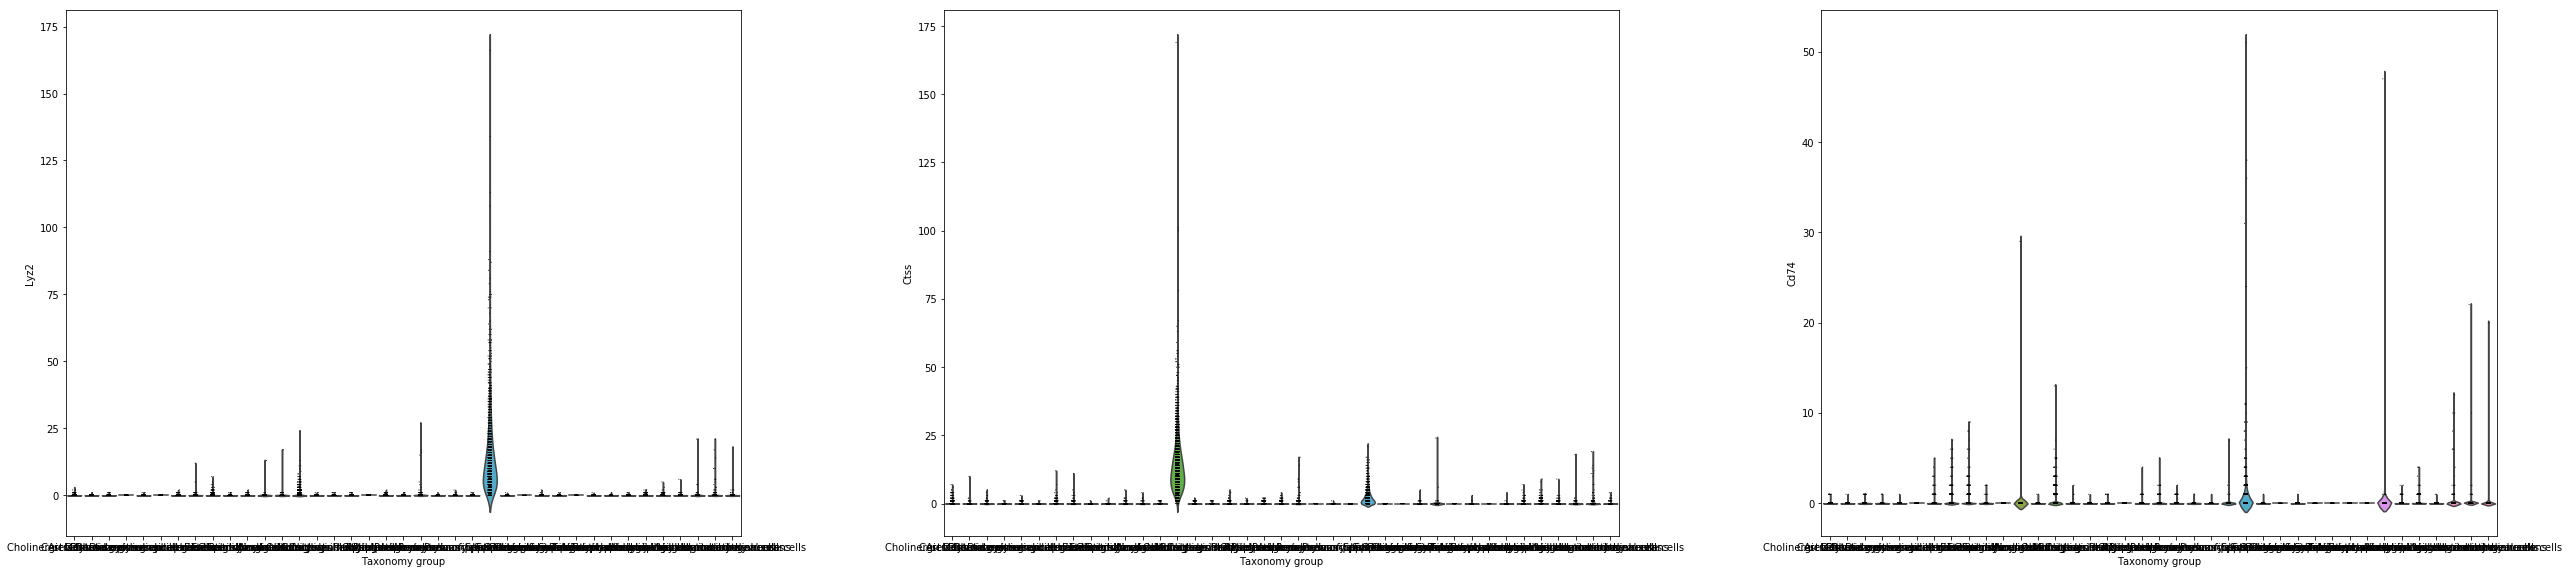

In [131]:
sc.pl.violin(adata_zeisel, ['Lyz2', 'Ctss', 'Cd74'], groupby='Taxonomy_group')

**Conclusion** Peripheral Glia have most overlap with brain pericytes and we keep the ependymal cells as extra category.

In [271]:
adata_zeisel.obs['Taxonomy_group'].cat.categories

Index(['Astrocytes', 'Cerebellum neurons',
       'Cholinergic and monoaminergic neurons', 'Choroid epithelial cells',
       'Dentate gyrus granule neurons', 'Dentate gyrus radial glia-like cells',
       'Di- and mesencephalon excitatory neurons',
       'Di- and mesencephalon inhibitory neurons', 'Ependymal cells',
       'Glutamatergic neuroblasts', 'Hindbrain neurons', 'Microglia',
       'Non-glutamatergic neuroblasts', 'Olfactory ensheathing cells',
       'Olfactory inhibitory neurons', 'Oligodendrocyte precursor cells',
       'Oligodendrocytes', 'Peptidergic neurons', 'Pericytes',
       'Perivascular macrophages', 'Spinal cord excitatory neurons',
       'Spinal cord inhibitory neurons',
       'Subcommissural organ hypendymal cells',
       'Subventricular zone radial glia-like cells',
       'Telencephalon inhibitory interneurons',
       'Telencephalon projecting excitatory neurons',
       'Telencephalon projecting inhibitory neurons',
       'Vascular and leptomeningeal

In [272]:
adata_zeisel.obs['cell_type'] = adata_zeisel.obs['Taxonomy_group'].cat.add_categories(['astrocyte', 
        'brain pericyte', 'endothelial cell','ependymal cell','neuron',
       'macrophage', 'microglial cell', 'oligodendrocyte',
                     'oligodendrocyte precursor cell',
                         'olfactory ensheathing cell', ])

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Astrocytes','Subventricular zone radial glia-like cells',
                                     'Dentate gyrus radial glia-like cells'])] =  'astrocyte'
adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Ependymal cells', 
                                      'Subcommissural organ hypendymal cells'])] = 'ependymal cell'
         
adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Perivascular macrophages'])] = 'macrophage'
adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Microglia'])] = 'microglial cell'
           
adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Telencephalon inhibitory interneurons',
       'Telencephalon projecting excitatory neurons',
       'Telencephalon projecting inhibitory neurons', 
                                      'Di- and mesencephalon excitatory neurons',
       'Di- and mesencephalon inhibitory neurons',
                                      'Cerebellum neurons',
       'Cholinergic and monoaminergic neurons',
                                      'Dentate gyrus granule neurons',
                                      'Non-glutamatergic neuroblasts',
                                      'Glutamatergic neuroblasts', 'Hindbrain neurons',
                                      'Spinal cord excitatory neurons',
                                      'Olfactory inhibitory neurons',
                                      'Peptidergic neurons',
       'Spinal cord inhibitory neurons'])] = 'neuron'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Oligodendrocytes'])] = 'oligodendrocyte'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Oligodendrocyte precursor cells'])] = 'oligodendrocyte precursor cell'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Olfactory ensheathing cells'])] = 'olfactory ensheathing cell'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Pericytes'])] = 'brain pericyte'

adata_zeisel.obs['cell_type'][np.in1d(adata_zeisel.obs['Taxonomy_group'], 
                                     ['Vascular and leptomeningeal cells', 'Vascular endothelial cells',
       'Vascular smooth muscle cells', 'Choroid epithelial cells'])] = 'endothelial cell'

adata_zeisel.obs['cell_type'] = adata_zeisel.obs['cell_type'].cat.remove_unused_categories()


In [273]:
adata_zeisel.obs['cell_type'].value_counts()

neuron                            70968
oligodendrocyte                   30253
astrocyte                         20460
endothelial cell                   7387
microglial cell                    5425
brain pericyte                     5213
olfactory ensheathing cell         2031
macrophage                         2029
ependymal cell                     1368
oligodendrocyte precursor cell      820
Name: cell_type, dtype: int64

In [41]:
adata_zeisel.obs['study'] = 'Zeisel'

In [ ]:
##Keep tissue, subclass, age and region.
#adata_zeisel.obs['Region']
#adata_zeisel.obs['Age']
#adata_zeisel.obs['Subclass']
#adata_zeisel.obs['Tissue']

In [130]:
del adata_zeisel.obs['AnalysisPool']
del adata_zeisel.obs['AnalysisProject']
del adata_zeisel.obs['Bucket']
del adata_zeisel.obs['CellConc']
del adata_zeisel.obs['Cell_Conc']
del adata_zeisel.obs['ChipID']
del adata_zeisel.obs['Class']
del adata_zeisel.obs['ClassProbability_Astrocyte']
del adata_zeisel.obs['ClassProbability_Astrocyte,Immune']
del adata_zeisel.obs['ClassProbability_Astrocyte,Neurons']
del adata_zeisel.obs['ClassProbability_Astrocyte,Oligos']
del adata_zeisel.obs['ClassProbability_Astrocyte,Vascular']
del adata_zeisel.obs['ClassProbability_Bergmann-glia']
del adata_zeisel.obs['ClassProbability_Blood']
del adata_zeisel.obs['ClassProbability_Blood,Vascular']
del adata_zeisel.obs['ClassProbability_Enteric-glia']
del adata_zeisel.obs['ClassProbability_Enteric-glia,Cycling']
del adata_zeisel.obs['ClassProbability_Ependymal']
del adata_zeisel.obs['ClassProbability_Ex-Neurons']
del adata_zeisel.obs['ClassProbability_Ex-Vascular']
del adata_zeisel.obs['ClassProbability_Immune']
del adata_zeisel.obs['ClassProbability_Immune,Neurons']
del adata_zeisel.obs['ClassProbability_Immune,Oligos']
del adata_zeisel.obs['ClassProbability_Neurons']
del adata_zeisel.obs['ClassProbability_Neurons,Cycling']
del adata_zeisel.obs['ClassProbability_Neurons,Oligos']
del adata_zeisel.obs['ClassProbability_Neurons,Satellite-glia']
del adata_zeisel.obs['ClassProbability_Neurons,Vascular']
del adata_zeisel.obs['ClassProbability_OEC']
del adata_zeisel.obs['ClassProbability_Oligos']
del adata_zeisel.obs['ClassProbability_Oligos,Cycling']
del adata_zeisel.obs['ClassProbability_Oligos,Vascular']
del adata_zeisel.obs['ClassProbability_Satellite-glia']
del adata_zeisel.obs['ClassProbability_Satellite-glia,Cycling']
del adata_zeisel.obs['ClassProbability_Satellite-glia,Schwann']
del adata_zeisel.obs['ClassProbability_Schwann']
del adata_zeisel.obs['ClassProbability_Ttr'] 
del adata_zeisel.obs['ClassProbability_Vascular']
del adata_zeisel.obs['ClusterName']
del adata_zeisel.obs['Clusters']
del adata_zeisel.obs['Comment']
del adata_zeisel.obs['Comments']
del adata_zeisel.obs['DateCaptured']
del adata_zeisel.obs['Date_Captured']
del adata_zeisel.obs['Description']
del adata_zeisel.obs['Developmental_compartment']
del adata_zeisel.obs['DonorID']
del adata_zeisel.obs['Estimated Number of Cells']
del adata_zeisel.obs['Flowcell']
del adata_zeisel.obs['Fraction Reads in Cells']
del adata_zeisel.obs['Label']
del adata_zeisel.obs['LeafOrder']
del adata_zeisel.obs['Location_based_on']
del adata_zeisel.obs['Mean Reads per Cell']
del adata_zeisel.obs['Median Genes per Cell']
del adata_zeisel.obs['Median UMI Counts per Cell']
del adata_zeisel.obs['MitoRiboRatio']
del adata_zeisel.obs['NGI_PlateWell']
del adata_zeisel.obs['Neurotransmitter']
del adata_zeisel.obs['NumPooledAnimals']
del adata_zeisel.obs['Num_Pooled_Animals']
del adata_zeisel.obs['Number of Reads']
del adata_zeisel.obs['OriginalClusters']
del adata_zeisel.obs['Outliers']
del adata_zeisel.obs['PCRCycles']
del adata_zeisel.obs['PCR_Cycles']
del adata_zeisel.obs['PassedQC']
del adata_zeisel.obs['PlugDate']
del adata_zeisel.obs['Plug_Date']
del adata_zeisel.obs['Probable_location']
del adata_zeisel.obs['Project']
del adata_zeisel.obs['Q30 Bases in Barcode']
del adata_zeisel.obs['Q30 Bases in RNA Read']
del adata_zeisel.obs['Q30 Bases in Sample Index']
del adata_zeisel.obs['Q30 Bases in UMI']
del adata_zeisel.obs['Reads Mapped Confidently to Exonic Regions']

In [129]:
del adata_zeisel.obs['Reads Mapped Confidently to Intergenic Regions']
del adata_zeisel.obs['Reads Mapped Confidently to Intronic Regions']
del adata_zeisel.obs['Reads Mapped Confidently to Transcriptome']
del adata_zeisel.obs['SampleID']
del adata_zeisel.obs['SampleIndex']
del adata_zeisel.obs['SampleOK']
del adata_zeisel.obs['Sample_Index']
del adata_zeisel.obs['SeqComment']
del adata_zeisel.obs['SeqLibDate']
del adata_zeisel.obs['SeqLibOk']
del adata_zeisel.obs['Seq_Comment']
del adata_zeisel.obs['Seq_Lib_Date']
del adata_zeisel.obs['Seq_Lib_Ok']
del adata_zeisel.obs['Sequencing Saturation']
del adata_zeisel.obs['Serial_Number']
del adata_zeisel.obs['Sex']
del adata_zeisel.obs['Species']
del adata_zeisel.obs['Strain']
del adata_zeisel.obs['TargetNumCells']
del adata_zeisel.obs['Target_Num_Cells']
del adata_zeisel.obs['TaxonomyRank1']
del adata_zeisel.obs['TaxonomyRank2']
del adata_zeisel.obs['TaxonomyRank3']
del adata_zeisel.obs['TaxonomyRank4']
del adata_zeisel.obs['TaxonomySymbol']
del adata_zeisel.obs['TimepointPool']
del adata_zeisel.obs['Total Genes Detected']
del adata_zeisel.obs['Transcriptome']
del adata_zeisel.obs['Valid Barcodes']
del adata_zeisel.obs['_KMeans_10']
del adata_zeisel.obs['_LogCV']
del adata_zeisel.obs['_LogMean']
del adata_zeisel.obs['_NGenes']
del adata_zeisel.obs['_PC1']
del adata_zeisel.obs['_PC2']
del adata_zeisel.obs['_Total']
del adata_zeisel.obs['_Valid']
del adata_zeisel.obs['_X']
del adata_zeisel.obs['_Y']
del adata_zeisel.obs['_tSNE1']
del adata_zeisel.obs['_tSNE2']
del adata_zeisel.obs['cDNAConcNanogramPerMicroliter']
del adata_zeisel.obs['cDNALibOk']
del adata_zeisel.obs['cDNA_Lib_Ok']
del adata_zeisel.obs['ngperul_cDNA']

In [274]:
del adata_zeisel.var['Accession']
del adata_zeisel.var['_LogCV']
del adata_zeisel.var['_LogMean']
del adata_zeisel.var['_Selected']
del adata_zeisel.var['_Total']
del adata_zeisel.var['_Valid']

In [275]:
adata_zeisel

AnnData object with n_obs × n_vars = 145954 × 27998 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'region', 'cell_type'

In [276]:
sc.write(adata=adata_zeisel, filename='zeisel_regions.h5ad')

## Tabula Muris - Brain

The Tabula Muris dataset contains data from all organs of the mouse. We concentrate on the brain. Here, we have two datasets (myeloid and non-myeloid). 

In [74]:
adata_tamu_myel = sc.read_csv('./../../DL_annotation/mouse_brain_data/Tabula_muris_2018/FACS/Brain_Myeloid-counts.csv').T

In [75]:
adata_tamu_nonmyel = sc.read_csv('./../../DL_annotation/mouse_brain_data/Tabula_muris_2018/FACS/Brain_Non-Myeloid-counts.csv').T

In [76]:
adata_tamu_myel

AnnData object with n_obs × n_vars = 4762 × 23433 

In [77]:
adata_tamu_nonmyel

AnnData object with n_obs × n_vars = 5799 × 23433 

Merge brain dataset objects from Tabula Muris. 

In [78]:
adata_tamu = adata_tamu_myel.concatenate(adata_tamu_nonmyel)

In [79]:
adata_tamu

AnnData object with n_obs × n_vars = 10561 × 23433 
    obs: 'batch'

Convert Tabula Muris dataset into a sparse matrix.

In [80]:
adata_tamu.X = sci.sparse.csr_matrix(adata_tamu.X)

In [81]:
test = [x for x in adata_tamu.obs_names.str.split('-')]

In [82]:
adata_tamu.obs_names = [x[0] for x in test]

Load annotation file.

In [83]:
anno_tamu = pd.read_csv('./../../DL_annotation/mouse_brain_data/Tabula_muris_2018/annotations_FACS.csv', 
                        low_memory=False)
meta_tamu = pd.read_csv('./../../DL_annotation/mouse_brain_data/Tabula_muris_2018/metadata_FACS.csv')

In [84]:
anno_tamu.shape

(44949, 24)

In [85]:
anno_tamu.columns

Index(['Neurog3>0_raw', 'Neurog3>0_scaled', 'cell', 'cell_ontology_class',
       'cell_ontology_id', 'cluster.ids', 'free_annotation', 'mouse.id',
       'mouse.sex', 'plate.barcode', 'subsetA', 'subsetA_cluster.ids',
       'subsetB', 'subsetB_cluster.ids', 'subsetC', 'subsetC_cluster.ids',
       'subsetD', 'subsetD_cluster.ids', 'subsetE', 'subsetE_cluster.ids',
       'subtissue', 'tissue', 'tissue_tSNE_1', 'tissue_tSNE_2'],
      dtype='object')

In [86]:
red_idx2 = np.isin(adata_tamu.obs.index, anno_tamu.cell)

In [87]:
red_idx2.sum()

7856

In [90]:
adata_tamu = adata_tamu[red_idx2,:]

In [91]:
red_idx = np.isin(anno_tamu.cell,adata_tamu.obs.index)

In [92]:
anno_tamu_red = anno_tamu.loc[red_idx ,:]

In [93]:
anno_tamu_red.index = anno_tamu_red.cell

In [94]:
pd.value_counts(anno_tamu_red.subtissue)

Striatum       2284
Cortex         2165
Hippocampus    2090
Cerebellum     1317
Name: subtissue, dtype: int64

In [95]:
pd.value_counts(anno_tamu_red.cell_ontology_class)

microglial cell                     4394
oligodendrocyte                     1574
endothelial cell                     715
astrocyte of the cerebral cortex     432
neuron                               281
oligodendrocyte precursor cell       203
brain pericyte                       156
macrophage                            61
Bergmann glial cell                   40
Name: cell_ontology_class, dtype: int64

In [96]:
adata_tamu.obs['cell_ontology_class'] = anno_tamu_red.cell_ontology_class
adata_tamu.obs['cell_ontology_class'] = adata_tamu.obs['cell_ontology_class'].astype('category')
adata_tamu.obs['cell_ontology_id'] = anno_tamu_red.cell_ontology_id
adata_tamu.obs['cell_ontology_id'] = adata_tamu.obs['cell_ontology_id'].astype('category')

adata_tamu.obs['region'] = anno_tamu_red.subtissue
adata_tamu.obs['region'].loc[pd.isnull(adata_tamu.obs['region'])] ='Unknown'
adata_tamu.obs['region'] = adata_tamu.obs['region'].astype('category')

Trying to set attribute `.obs` of view, making a copy.
/home/icb/maren.buettner/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [97]:
adata_tamu.obs['region'].cat.categories

Index(['Cerebellum', 'Cortex', 'Hippocampus', 'Striatum'], dtype='object')

Rename regions to fit with the other data sets.

In [98]:
tabula_dict = dict({'Cerebellum' : 'CB', 
                    'Cortex' : 'CTX', 
                    'Hippocampus' : 'HC', 
                    'Striatum' : 'STR'})

In [99]:
adata_tamu.obs['region'] = adata_tamu.obs['region'].cat.rename_categories(tabula_dict)

In [100]:
adata_tamu.obs['region'].value_counts()

STR    2284
CTX    2165
HC     2090
CB     1317
Name: region, dtype: int64

In [101]:
adata_tamu.obs['study'] = 'Tabula_muris'

In [104]:
adata_tamu.obs['cell_ontology_class'].value_counts()

microglial cell                     4394
oligodendrocyte                     1574
endothelial cell                     715
astrocyte of the cerebral cortex     432
neuron                               281
oligodendrocyte precursor cell       203
brain pericyte                       156
macrophage                            61
Bergmann glial cell                   40
Name: cell_ontology_class, dtype: int64

In [105]:
adata_tamu.obs['cell_ontology_class'].cat.categories

Index(['Bergmann glial cell', 'astrocyte of the cerebral cortex',
       'brain pericyte', 'endothelial cell', 'macrophage', 'microglial cell',
       'neuron', 'oligodendrocyte', 'oligodendrocyte precursor cell'],
      dtype='object')

Apply the rough annotation to the Tabula muris data, i.e. merge Bergmann glial cell and astrocytes. 

In [106]:
adata_tamu.obs['cell_type'] = adata_tamu.obs['cell_ontology_class'].cat.add_categories(['astrocyte'])

adata_tamu.obs['cell_type'][np.in1d(adata_tamu.obs['cell_ontology_class'], 
                                     ['Bergmann glial cell', 'astrocyte of the cerebral cortex'])] =  'astrocyte'

adata_tamu.obs['cell_type'] = adata_tamu.obs['cell_type'].cat.remove_unused_categories()

In [107]:
adata_tamu.obs['cell_type'].value_counts()

microglial cell                   4394
oligodendrocyte                   1574
endothelial cell                   715
astrocyte                          472
neuron                             281
oligodendrocyte precursor cell     203
brain pericyte                     156
macrophage                          61
Name: cell_type, dtype: int64

Remove ERCC tags from genes.

In [108]:
ercc_idx = np.array([tag.startswith('ERCC') for tag in adata_tamu.var_names])

In [109]:
adata_tamu = adata_tamu[:, np.invert(ercc_idx)].copy()

Visualise the data.

In [118]:
sc.pp.neighbors(adata_tamu)
sc.tl.louvain(adata_tamu)
sc.tl.umap(adata_tamu)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:03)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:05)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 19 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


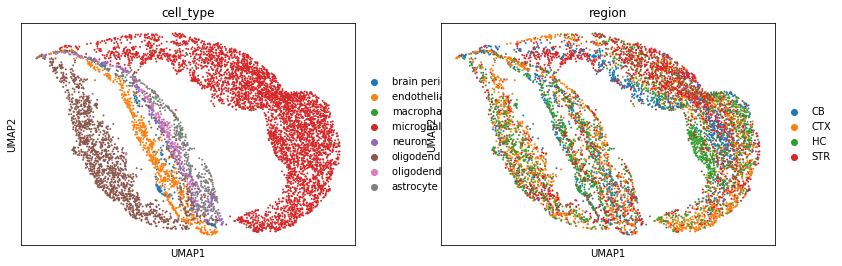

In [120]:
sc.pl.umap(adata_tamu, color=['cell_type', 'region'])

In [110]:
adata_neuron = adata_tamu[adata_tamu.obs['cell_type']=='neuron'].copy()

In [111]:
sc.pp.log1p(adata_neuron)

In [112]:
sc.pp.neighbors(adata_neuron)
sc.tl.louvain(adata_neuron)
sc.tl.umap(adata_neuron)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


... storing 'study' as categorical


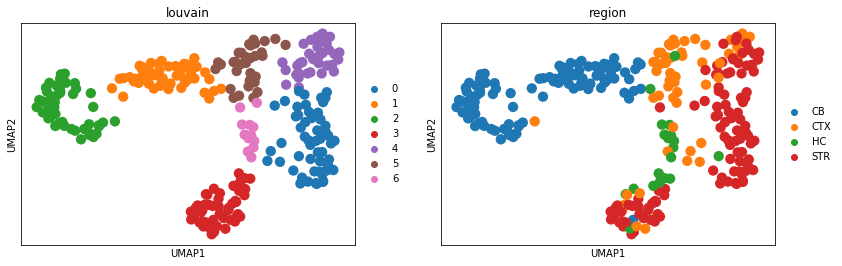

In [113]:
sc.pl.umap(adata_neuron, color=['louvain', 'region'])

In [114]:
sc.tl.rank_genes_groups(adata_neuron, 'louvain')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_louvain']`


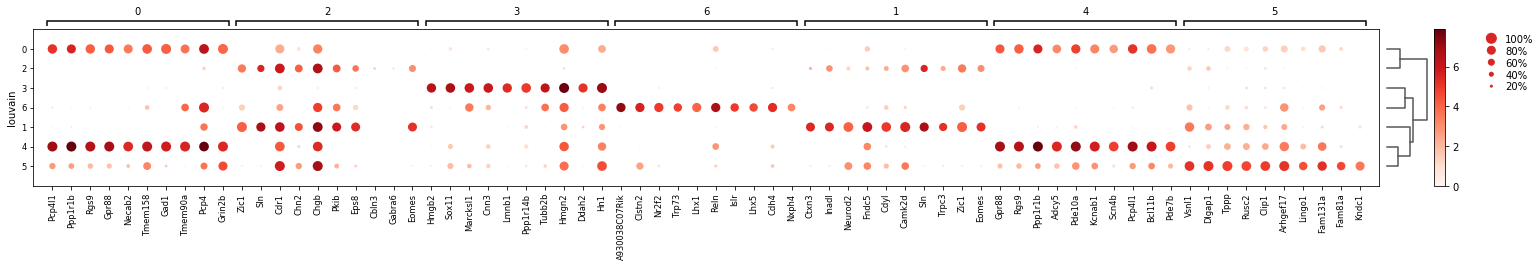

In [115]:
sc.pl.rank_genes_groups_dotplot(adata_neuron)

Refining tabula muris neurons leads to inconclusive results with respect to neuronal subtypes.

Write to file.

In [121]:
sc.write(adata=adata_tamu, filename='tabula_muris.h5ad')

Free memory.

In [218]:
#del adata_tamu
del adata_tamu_myel
del adata_tamu_nonmyel

# Merge studies

In the last step, we merge all studies.

In [8]:
adata_saunders = sc.read('saunders_regions.h5ad')
adata_zeisel = sc.read('zeisel_regions.h5ad')
adata_rosen = sc.read('rosenberg_regions.h5ad')
adata_tamu = sc.read('tabula_muris.h5ad')

In [9]:
adata_rosen.obs['study'] = 'Rosenberg'
adata_zeisel.obs['study'] = 'Zeisel'

In [10]:
adata_all = adata_tamu.concatenate(adata_saunders, adata_zeisel)
adata_all = adata_all.concatenate(adata_rosen)

In [11]:
pd.crosstab(adata_all.obs['study'], adata_all.obs['cell_type'])

cell_type     astrocyte  brain pericyte  endothelial cell  ependymal cell  \
study                                                                       
Rosenberg         10683            1188               474             400   
Saunders          56915           12135             46455            2083   
Tabula_muris        472             156               715               0   
Zeisel            20460            5213              7387            1368   

cell_type     macrophage  microglial cell  neuron  olfactory ensheathing cell  \
study                                                                           
Rosenberg             53              485  113829                         255   
Saunders            1701             5551  443157                           0   
Tabula_muris          61             4394     281                           0   
Zeisel              2029             5425   70968                        2031   

cell_type     oligodendrocyte  oligodendrocyte precursor cell  
study                                                          
Rosenberg                1566                            4502  
Saunders               110867                           12625  
Tabula_muris             1574                             203  
Zeisel                  30253                             820

In [12]:
adata_all

AnnData object with n_obs × n_vars = 978734 × 14858 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'

**Suggestions**: We may resolve the annotation of the neurons, where Rosenberg et al and Zeisel et al spend a lot of effort on. The annotation from Saunders et al, however, seems useless to me.

In [13]:
sc.write(adata=adata_all, filename='mouse_brain_regions.h5ad')

... storing 'Age' as categorical
... storing 'Subclass' as categorical
... storing 'Taxonomy_group' as categorical
... storing 'Tissue' as categorical
... storing 'age' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'cell_type' as categorical
... storing 'class' as categorical
... storing 'cluster' as categorical
... storing 'cluster_id' as categorical
... storing 'louvain' as categorical
... storing 'reason' as categorical
... storing 'refined_class' as categorical
... storing 'region' as categorical
... storing 'region_subcluster' as categorical
... storing 'sample_type' as categorical
... storing 'study' as categorical
... storing 'subcluster' as categorical
